# Hands-on Example:

In [1]:
#Data loading and HapMap class dependencies:
import pandas as pd
import numpy as np

#Data visualization:
import matplotlib.pyplot as plt
from matplotlib.patches import ConnectionPatch
from matplotlib.gridspec import GridSpec
import seaborn as sns

#Data transformation
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MinMaxScaler

#HapMap Class, subclasses and preprocessing functions
from scripts.HapMap import HapMap, MarkerS
from scripts.Prepro import PreproG

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

#### 1. Load HapMap file

In [2]:
file = 'HapMap_Data/HapMap.hmp.txt'

In [3]:
df = pd.read_table(file, low_memory=False)

In [4]:
df.head()

,rs#,alleles,chrom,pos,strand,assembly#,center,protLSID,assayLSID,panelLSID,...,C061,B091,H191,B10,B11,B12,H071,E121,D041,C071
0,S01_37506,G/A,1,37506,+,NaN,NaN,NaN,NaN,NaN,...,G,N,N,G,N,G,G,N,N,N
1,S01_37540,T/A,1,37540,+,NaN,NaN,NaN,NaN,NaN,...,T,N,N,T,N,T,T,N,N,N
2,S01_68160,G/A,1,68160,+,NaN,NaN,NaN,NaN,NaN,...,N,G,R,N,G,G,N,N,N,N
3,S01_123283,A/G,1,123283,+,NaN,NaN,NaN,NaN,NaN,...,N,N,A,N,N,N,N,A,N,N
4,S01_123300,A/G,1,123300,+,NaN,NaN,NaN,NaN,NaN,...,N,N,A,N,N,N,N,A,N,N


#### 2. Create an instance of MarkerS (HapMap subclass):

The hap map class is an abstract class that derived the implementation of certain methods to the MarkerS (HapMap subclass). To properly create a hapmap class and explore the HapMap files through their atributes it has to be instantiate through the MarkerS class:

In [5]:
HapMap = MarkerS(df)

*Once created **ONLY**  biallelic markers will consider for further operations*

#### 3. Explore some HapMap useful atributes:


* **3.1 The describe_density** atribute will return a dictionary with the number of markers evaluated per chromosome (in case scaffolds have been used, it will also include the scaffold code with the associated number of sequences per scaffold), this gives us insight of the overall coverage of our genotyped.

In [6]:
HapMap.describe_density

{'1': 532,
 '2': 514,
 '3': 606,
 '4': 628,
 '5': 375,
 '6': 449,
 '7': 500,
 '8': 528,
 '9': 585,
 '10': 626,
 '11': 280,
 '12': 299,
 '13': 697,
 '14': 593,
 '15': 818,
 '16': 575,
 '17': 447,
 '18': 1003,
 '19': 564,
 '20': 393,
 'SCAFFOLD_101': 2,
 'SCAFFOLD_107': 2,
 'SCAFFOLD_110': 1,
 'SCAFFOLD_116': 1,
 'SCAFFOLD_121': 1,
 'SCAFFOLD_1317': 1,
 'SCAFFOLD_136': 2,
 'SCAFFOLD_1400': 67,
 'SCAFFOLD_141': 1,
 'SCAFFOLD_1430': 8,
 'SCAFFOLD_146': 1,
 'SCAFFOLD_1522': 1,
 'SCAFFOLD_164': 10,
 'SCAFFOLD_168': 2,
 'SCAFFOLD_1781': 3,
 'SCAFFOLD_187': 1,
 'SCAFFOLD_198': 2,
 'SCAFFOLD_2017': 28,
 'SCAFFOLD_208': 1,
 'SCAFFOLD_21': 6,
 'SCAFFOLD_2104': 3,
 'SCAFFOLD_216': 1,
 'SCAFFOLD_2198': 1,
 'SCAFFOLD_22': 2,
 'SCAFFOLD_23': 8,
 'SCAFFOLD_24': 14,
 'SCAFFOLD_25': 1,
 'SCAFFOLD_258': 2,
 'SCAFFOLD_26': 2,
 'SCAFFOLD_262': 1,
 'SCAFFOLD_27': 3,
 'SCAFFOLD_28': 4,
 'SCAFFOLD_30': 2,
 'SCAFFOLD_31': 2,
 'SCAFFOLD_317': 52,
 'SCAFFOLD_32': 1,
 'SCAFFOLD_33': 4,
 'SCAFFOLD_34': 4,
 'SCAFFO

* **3.2 The GENOS_n** atribute will return a scalar with the number of individuals in the population:

In [7]:
HapMap.GENOS_n

190

* **3.3 The .SNP_n** atribute will return a scalar with the number of markers:

In [8]:
HapMap.SNP_n

11312

* **3.3 The AF** atribute will return a dictionary with the frequency associated with each variant

In [9]:
for i, key in enumerate(HapMap.AF):
    print(key, HapMap.AF[key])
    if i == 3:
        break

S01_37506 {'A': 0.031578947368421054, 'G': 0.4473684210526316, 'N': 0.5157894736842106, 'R': 0.005263157894736842}
S01_37540 {'A': 0.031578947368421054, 'N': 0.5157894736842106, 'T': 0.4473684210526316, 'W': 0.005263157894736842}
S01_68160 {'A': 0.03684210526315789, 'G': 0.21052631578947367, 'N': 0.7473684210526316, 'R': 0.005263157894736842}
S01_123283 {'A': 0.32105263157894737, 'G': 0.07894736842105263, 'N': 0.6}


#### 4. Create homozygous and heterozygous arrrays:

In [10]:
hom, het = MarkerS(df), MarkerS(df)

In [11]:
hom_d = hom.Homozygous(numeric = True)#by default -1 is assign to the most frequent variant and 1 to the MAF (Minor Alelle frequency) 
het_d = het.Heterozygous(numeric = True)#by default 0, just considering the bialllelic variants with the most common and MAF variants

In [12]:
print(np.unique(hom.value))
print(np.unique(het.value))

[-1.  1. nan]
[ 0. nan]


The objective of creating separatlely arrays with homozygous and heterozygous information is being able to generate different types of analysis depending on the context.

In [13]:
k = hom.collapse(het, output_format = 'DF')#we can collapse both of the arrays in order to keep both, homozygous and heterozygous

In [14]:
k.head()

,MRK,CHR,MAF,A01,A02,A03,A04,A05,A06,A07,...,C061,B091,H191,B10,B11,B12,H071,E121,D041,C071
0,S01_37506,1,A,NaN,-1.0,NaN,NaN,NaN,-1.0,NaN,...,-1.0,NaN,NaN,-1.0,NaN,-1.0,-1.0,NaN,NaN,NaN
1,S01_37540,1,A,NaN,-1.0,NaN,NaN,NaN,-1.0,NaN,...,-1.0,NaN,NaN,-1.0,NaN,-1.0,-1.0,NaN,NaN,NaN
2,S01_68160,1,A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,-1.0,0.0,NaN,-1.0,-1.0,NaN,NaN,NaN,NaN
3,S01_123283,1,G,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,-1.0,NaN,NaN
4,S01_123300,1,G,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,-1.0,NaN,NaN


#### 5. PreproG, a class with methods that automates data filtration:

In [15]:
g = PreproG(k)

In [16]:
g.frame.sample(5)

,MRK,CHR,MAF,A01,A02,A03,A04,A05,A06,A07,...,C061,B091,H191,B10,B11,B12,H071,E121,D041,C071
524,S01_56782528,1,G,NaN,0.0,-1.0,NaN,1.0,1.0,1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,0.0,-1.0,-1.0
9538,S18_26852761,18,T,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
8198,S16_12332080,16,T,NaN,-1.0,NaN,-1.0,NaN,NaN,NaN,...,-1.0,NaN,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,NaN
4816,S10_7725179,10,C,NaN,NaN,NaN,-1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,NaN,NaN
6846,S14_16216022,14,G,NaN,NaN,1.0,NaN,NaN,1.0,NaN,...,NaN,1.0,-1.0,NaN,1.0,1.0,-1.0,1.0,NaN,NaN


In [17]:
#delete scaffolds:
cutting_values = g.frame[g.frame.CHR.str.contains('SCAFFOLD')].index.tolist()
g.cut(cutting_values)

In [18]:
print('Number of markers after scaffolds extraction:')
g.frame.shape[0]

Number of markers after scaffolds extraction:


11012

In [19]:
#delete all markers with a frequency of missing values over a 50%:
g.cut_by_miss_frq(missing_data = np.nan,numeric = True ,frq =50, apply = True)
print('Number of markers after missing values extraction:')
g.frame.shape[0]

Number of markers after missing values extraction:


5220

In [20]:
#delete all markers with a MAFs under a 5%:
g.cut_by_MAF(numeric = True, MA = 1, frq = 5, apply = True)

g.frame.shape

(3902, 193)

In [21]:
#Impute marker matrix for reduction dimensionality and population structure inference:
g_impute = g.impute(strategy = 'mean', structure = 'DF')

In [22]:
g_impute.head()

,S01_153541,S01_156650,S01_293684,S01_293924,S01_294507,S01_378527,S01_382258,S01_385049,S01_385095,S01_393862,...,S20_46862441,S20_46954952,S20_46955024,S20_47277643,S20_47365933,S20_47480812,S20_47544340,S20_47576748,S20_47706065,S20_47883292
A01,-0.753418,-0.737793,-0.351807,-1.0,-1.00000,-0.084595,-1.0,-0.785156,-0.042023,-0.779297,...,-0.793457,-0.112122,-0.094849,-0.736328,-1.0,-0.007042,1.00000,-0.054871,1.0,1.0
A02,-1.000000,-1.000000,-1.000000,-1.0,-1.00000,1.000000,-1.0,-1.000000,-1.000000,-1.000000,...,-1.000000,-0.112122,-1.000000,-1.000000,-1.0,1.000000,1.00000,0.000000,1.0,1.0
A03,-1.000000,-0.737793,-0.351807,1.0,-0.22522,-1.000000,-1.0,-0.785156,1.000000,-1.000000,...,-0.793457,1.000000,-0.094849,-1.000000,-1.0,-0.007042,-0.14502,1.000000,1.0,1.0
A04,-0.753418,-0.737793,-1.000000,-1.0,-1.00000,1.000000,-1.0,-0.785156,-0.042023,-0.779297,...,-0.793457,-0.112122,1.000000,-0.736328,-1.0,-0.007042,-1.00000,-0.054871,-1.0,-1.0
A05,1.000000,-0.737793,-1.000000,-1.0,-0.22522,-1.000000,1.0,-0.785156,-0.042023,-0.779297,...,-0.793457,-0.112122,-0.094849,-0.736328,-1.0,-0.007042,-0.14502,-1.000000,-1.0,-1.0


#### 6. Application of PCA: 

**Some previous considerations:** due to the preprocessing done above there is no need to rescale data, data is already scaled between -1 and 1, therfore no significant differences between the scale of atributes will incur prejudice against PCA or K-means performances.

In [23]:
pca = PCA(n_components = 0.95)#with the n_components arguments we asure that we are able to explain at least a 95% of variation
#our data population:
pca.fit(g_impute)
reduced = pca.transform(g_impute)

In [24]:
len(pca.explained_variance_ratio_)

154

As we see, we have made a consdiderable dimension reduction, from 3902 atributes (markers), to a 154 atributes or components that represents the 95% of data variance. In the cell above we can geometrically represent the cumulative variance through the components:

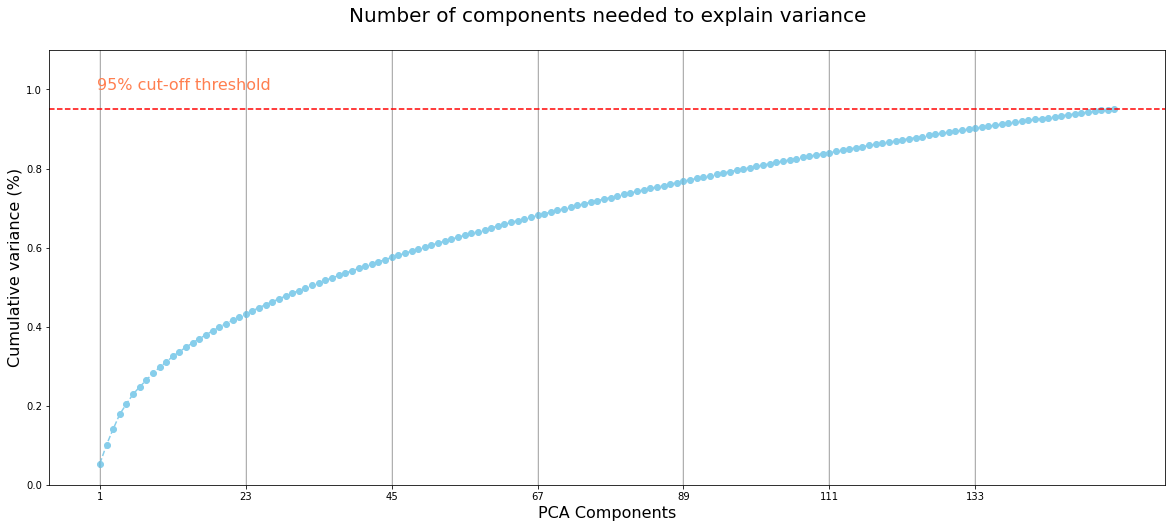

In [25]:
fig, ax = plt.subplots(figsize = (20,8))
components = np.arange(1, 155, step=1)
variance = np.cumsum(pca.explained_variance_ratio_)

plt.ylim(0.0,1.1)
ax.plot(components, variance, marker='o', linestyle='--', color='skyblue')

plt.xlabel('PCA Components', fontsize=16)
plt.xticks(range(1,155,22))
plt.ylabel('Cumulative variance (%)', fontsize=16)
ax.set_title('Number of components needed to explain variance\n', fontsize=20)


for i in range(1,155,22):
    ax.axvline(x=i, color='k', linestyle='-', alpha = .1)
ax.axhline(y=0.95, color='r', linestyle='--')
ax.text(0.5, 1., '95% cut-off threshold', color = 'coral', fontsize=16)

ax.grid(axis='x')
plt.show()

#### 7. Population inference with K-means: 

**A little bit of Kmeans first...**

K-means is an unsupervised learning clustering technique mainly used for data exploration, data mining, and information compression through quantization. 

K-means is a centroid model -each cluster is represented by a central point. “K” represents the number of clusters, and “mean” is the aggregation operation applied to elements of a cluster to define the central location. Central points are called centroids or prototypes of the clusters.

From a theoretical perspective, finding the optimal solution for a clustering problem is particularly difficult. Thus, all algorithms are only approximations of the optimal solution. The k-means algorithm, is an iterative process that refines the solution until it converges to a local optimum.

Given some data points and the number of clusters, the goal is to find the optimal centroids (those which minimize the within-cluster distance):

$$ C_{best} = arg min \sum\limits_{i=1}\sum\limits_{x\in S_{i}}||x-c_{i}||^{2}$$

where:

* x = denotes the set of data points of dimensions d
* C = set of centroids
* S = represents the groupings where $S_{i}$ is the set of data points contained in the cluster

K-Means training is as fallows:

* **Initialization**: Often, there is no good prior knowledge about the location of the centroids. An effortless way to start is to define the centroids by randomly selecting  data points from the dataset.

* **Assignment**: For each data point, the distance to all centroids is computed. The data points belong to the cluster represented by the closest centroid. This is called a hard assignment because the data point belongs to one and only one cluster.

* **Update**: Given all the points assigned to a cluster, the mean position is computed and defines the new location of the centroid

* **Repeat until convergence**

*In our particular case, due to the sensitivity of the algorithm to the initial locations of the centroids we are going to  initiate the centroids a couple of times (at least one hundred times)to, somehow, provide the best starting point, for this purpose we will create a function to automate customize run of our K-means and the collection of coefficients of interest such as centroid coordinates or silhouette coefficients (of which we willl be talking in the cells below). All these con be easily address with sklearn:*

In [26]:
def k_means_cust (DataFrame, up_to = 10):
    scores_by_group={}
    score_values=[]
    ERROR = []
    labels = []
    centroids_centers = []
    for i in range (2,up_to+1):
        kmeans=KMeans(n_clusters=i, n_init = 100, max_iter = 1000, random_state=0).fit(DataFrame)
        labels.append(kmeans.labels_)
        score=silhouette_score(DataFrame, kmeans.labels_)
        scores_by_group[i]=score
        print("number of clusters formed {}, silhouette score {}".format(str(i), str(score)))
        ERROR.append(kmeans.inertia_)
        centroids_centers.append(kmeans.cluster_centers_)
    return scores_by_group, score_values, ERROR, labels, centroids_centers

In [27]:
scores_by_group, score_values, ERROR, labels, centroids_centers = k_means_cust (reduced, up_to = 12)

number of clusters formed 2, silhouette score 0.0796909065424588
number of clusters formed 3, silhouette score 0.04933765075570664
number of clusters formed 4, silhouette score 0.042607906580481254
number of clusters formed 5, silhouette score 0.04379498784439109
number of clusters formed 6, silhouette score 0.039748392814875355
number of clusters formed 7, silhouette score 0.05003099540006065
number of clusters formed 8, silhouette score 0.045343509246376784
number of clusters formed 9, silhouette score 0.03912183190991842
number of clusters formed 10, silhouette score 0.03149071631401714
number of clusters formed 11, silhouette score 0.053358697343330354
number of clusters formed 12, silhouette score 0.02965060571559113


**How many clusters are the appropriate clusters?** Quality measurements, introducing the Silhouette coefficient

Silhouette coefficient is a quality measurement for partitioning. The silhouette score measures how close a data point is to its counterparts in the same cluster compared to other elements in other clusters. The score captures the cohesion (within-cluster distances) and the separation (inter-cluster distances), and is calculated as follows:

$$s(x) = \frac{b(x) - a(x)}{max \{a(x), b(x)\}}$$

where:
* **a** is the mean intra-cluster distance 
* **b** is the mean nearest-cluster distance

The best number of clusters yields the highest average silhouette coefficient. The best value is 1 and the worst value is -1. Values near 0 indicate overlapping clusters. Negative values generally indicate that a sample has been assigned to the wrong cluster, as a different cluster is more similar.


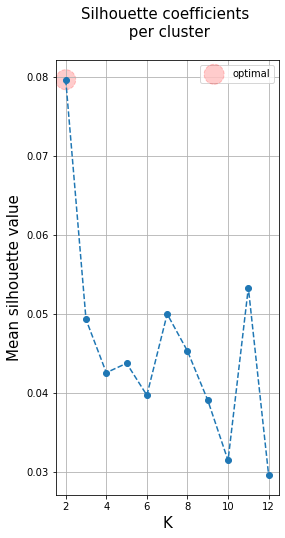

In [28]:
clusters = scores_by_group.keys()
silhouette_coefs = scores_by_group.values()

fig, ax1 = plt.subplots(figsize = (4, 8))
ax1.plot(clusters, silhouette_coefs, marker = 'o', linestyle = '--')
ax1.scatter(list(clusters)[0], list(silhouette_coefs)[0], 
           marker = 'o', linestyle = '--', s = 400, color = 'red', alpha = .2, label = 'optimal')
plt.title('Silhouette coefficients \n per cluster\n', size= 15)
plt.ylabel('Mean silhouette value', size = 15)
plt.xlabel('K', size = 15)
plt.grid()
plt.legend()
plt.show()

*In our case, eventhough we can rely on the Silhouette coefficient to select a preliminar number of clusters for population structure inference based on our HapMap data, these values are an indication of a not so clare structure underlying our data*

#### 8. Visualizing data structure:

In [29]:
#grouping data:
columns = [str(i) for i in range(1, reduced.shape[1]+1)]
df_ = pd.DataFrame(reduced, columns = columns, index = g_impute.index)
df_.insert(0,'cluster',labels[0])
df_.head()

,cluster,1,2,3,4,5,6,7,8,9,...,145,146,147,148,149,150,151,152,153,154
A01,0,-2.672667,-7.620678,0.626645,7.100085,5.260790,7.512311,-5.854532,-0.861914,0.613180,...,1.639963,1.009949,1.778340,1.853066,-5.064302,-3.646312,0.358411,-5.695740,2.153089,0.438015
A02,0,-1.327828,-10.066322,1.333772,23.355708,-3.868960,1.802430,-2.065987,-0.492539,6.738152,...,-0.290717,1.781811,-1.538503,0.752996,0.769794,-1.270035,1.265756,1.684026,2.604829,-1.618315
A03,0,7.370631,-6.790828,-2.184594,5.158016,-1.213547,-3.411411,9.361201,0.639741,1.873252,...,-1.414072,1.063967,-5.106698,-0.882129,-2.808296,-1.562797,1.865018,-0.876712,6.015995,1.650062
A04,0,-2.778581,-0.769746,4.127769,-1.749752,0.613023,-3.929887,1.858184,6.529613,0.928291,...,-2.705707,-1.293316,-1.504601,-2.014641,-2.865329,-0.715636,2.635154,0.253524,2.538862,3.182247
A05,0,8.800073,-13.963983,-2.042250,-1.622595,-1.568089,-7.971556,1.991100,-5.081648,0.654369,...,2.197598,5.217921,-1.415395,0.837662,-4.684095,0.757191,-0.400987,4.416548,0.180978,-3.445505


In [30]:
df_.head()

,cluster,1,2,3,4,5,6,7,8,9,...,145,146,147,148,149,150,151,152,153,154
A01,0,-2.672667,-7.620678,0.626645,7.100085,5.260790,7.512311,-5.854532,-0.861914,0.613180,...,1.639963,1.009949,1.778340,1.853066,-5.064302,-3.646312,0.358411,-5.695740,2.153089,0.438015
A02,0,-1.327828,-10.066322,1.333772,23.355708,-3.868960,1.802430,-2.065987,-0.492539,6.738152,...,-0.290717,1.781811,-1.538503,0.752996,0.769794,-1.270035,1.265756,1.684026,2.604829,-1.618315
A03,0,7.370631,-6.790828,-2.184594,5.158016,-1.213547,-3.411411,9.361201,0.639741,1.873252,...,-1.414072,1.063967,-5.106698,-0.882129,-2.808296,-1.562797,1.865018,-0.876712,6.015995,1.650062
A04,0,-2.778581,-0.769746,4.127769,-1.749752,0.613023,-3.929887,1.858184,6.529613,0.928291,...,-2.705707,-1.293316,-1.504601,-2.014641,-2.865329,-0.715636,2.635154,0.253524,2.538862,3.182247
A05,0,8.800073,-13.963983,-2.042250,-1.622595,-1.568089,-7.971556,1.991100,-5.081648,0.654369,...,2.197598,5.217921,-1.415395,0.837662,-4.684095,0.757191,-0.400987,4.416548,0.180978,-3.445505


In [31]:
#Selecting the apropiate dimension space for 2D representation, first 2 components:
k_0 = df_[df_['cluster'] == 0]
k_1 = df_[df_['cluster'] == 1]
data = (k_0, k_1)
centroids = (centroids_centers[0][0][0:2], centroids_centers[0][1][0:2])
components = pca.explained_variance_ratio_[:2]*100

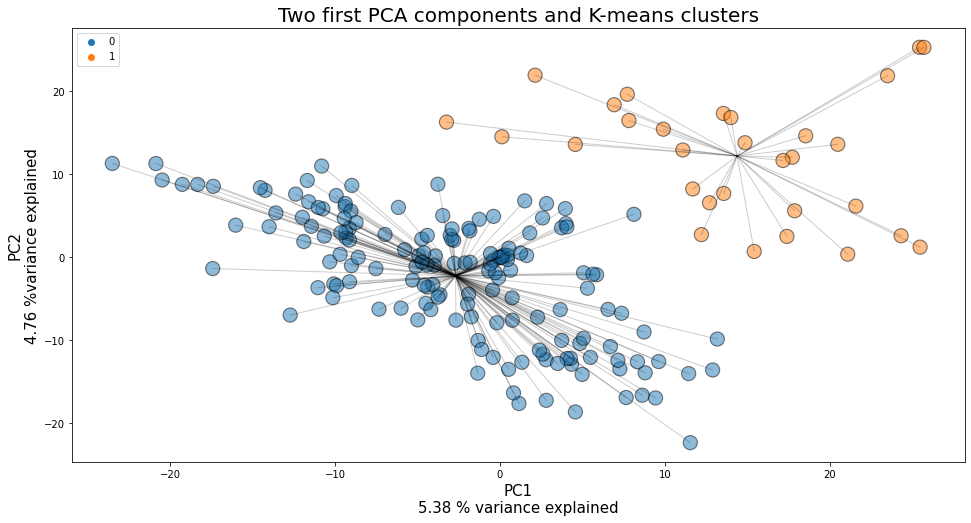

In [32]:
fig, ax = plt.subplots (figsize = (16,8))
sns.scatterplot(data = df_, x = '1' , y = '2', hue = 'cluster', s = 200, alpha = .5, ax = ax, edgecolor="k")

for i, df in enumerate(data):
    cntr = centroids[i]
    xy_coord = tuple(zip(df['1'], df['2']))
    for points in xy_coord:
        conexion = ConnectionPatch(cntr, points, 'data', 'data', arrowstyle="-", alpha = .2)
        ax.add_artist(conexion)
        
plt.title('Two first PCA components and K-means clusters', size= 20)
plt.xlabel('PC1\n{:.2f} % variance explained'.format(components[0]), size = 15)
plt.ylabel('PC2\n{:.2f} %variance explained'.format(components[1]), size = 15)
plt.legend()
plt.show()